# 1. 线性回归入门
## 1.1 数据生成

线性回归是机器学习算法的一个敲门砖，为了能够更方便直观地带大家入门，这里使用人工生成的简单的数据。生成数据的思路是设定一个二维的函数（维度高了没办法在平面上画出来），根据这个函数生成一些离散的数据点，对每个数据点我们可以适当的加一点波动，也就是噪声，最后看看我们算法的拟合或者说回归效果。

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

def true_fun(X): # 这是我们设定的真实函数，即ground truth的模型
    return 1.5*X + 0.2

np.random.seed(0) # 设置随机种子
n_samples = 30 # 设置采样数据点的个数

'''生成随机数据作为训练集，并且加一些噪声'''
X_train = np.sort(np.random.rand(n_samples)) 
y_train = (true_fun(X_train) + np.random.randn(n_samples) * 0.05).reshape(n_samples,1)

## 1.2 定义模型
生成数据之后，我们可以定义我们的算法模型，直接从sklearn库中导入类LinearRegression即可，由于线性回归比较简单，所以这个类的输入参数也比较少，不需要多加设置。
定义好模型之后直接训练，就能得到我们拟合的一些参数。

In [2]:
from sklearn.linear_model import LinearRegression # 导入线性回归模型
model = LinearRegression() # 定义模型
model.fit(X_train[:,np.newaxis], y_train) # 训练模型
print("输出参数w：",model.coef_) # 输出模型参数w
print("输出参数b：",model.intercept_) # 输出参数b

输出参数w： [[1.4474774]]
输出参数b： [0.22557542]


## 1.3 模型测试与比较
可以看到线性回归拟合的参数是1.44和0.22，很接近实际的1.5和0.2，说明我们的算法性能还不错。
下面我们直接选取一批数据测试，然后通过画图看看算法模型与实际模型的差距。

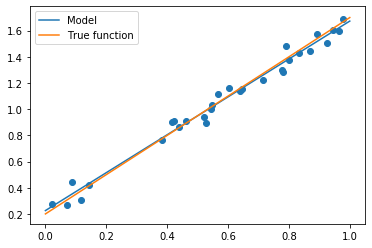

In [3]:
X_test = np.linspace(0, 1, 100)
plt.plot(X_test, model.predict(X_test[:, np.newaxis]), label="Model")
plt.plot(X_test, true_fun(X_test), label="True function")
plt.scatter(X_train,y_train) # 画出训练集的点
plt.legend(loc="best")
plt.show()

由于我们的数据比较简单，所以从图中也可以看出，我们的算法拟合曲线与实际的很接近。对于更复杂以及高维的情况，线性回归不能满足我们回归的需求，这时候我们需要用到更为高级一些的多项式回归了。

# 2. 多项式回归

多项式回归的思路一般是将$m$次多项式方程转化为$m$线性回归方程，即将$y=b_0+b_1*x+...+b_m*x^m$转换为$y=b_0*+b_1*x_1+...+b_m*x_m$（令$x_m=x^m$即可），然后使用线性回归的方法求出相应的参数。
一般实际的算法也是如此，我们将多项式特征分析器和线性回归串联，算出线性回归的参数之后倒推过去就行。

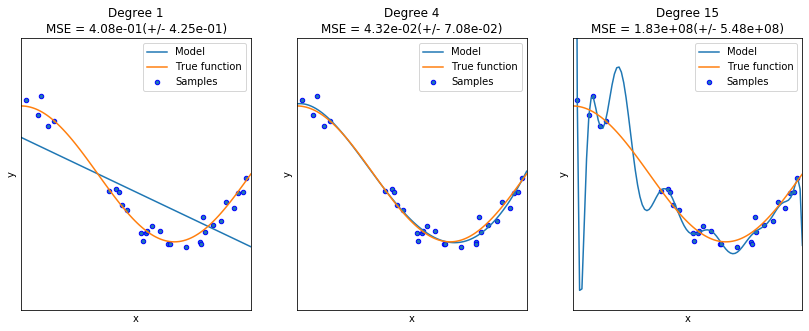

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures # 导入能够计算多项式特征的类
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

def true_fun(X): # 这是我们设定的真实函数，即ground truth的模型
    return np.cos(1.5 * np.pi * X)
np.random.seed(0)
n_samples = 30 # 设置随机种子

X = np.sort(np.random.rand(n_samples)) 
y = true_fun(X) + np.random.randn(n_samples) * 0.1

degrees = [1, 4, 15] # 多项式最高次
plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())
    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)]) # 使用pipline串联模型
    pipeline.fit(X[:, np.newaxis], y)
    
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,scoring="neg_mean_squared_error", cv=10) # 使用交叉验证
    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()

## 2.1 交叉验证
在这个算法训练过程中，我们使用了一个技巧，就是交叉验证，类似的方法还有holdout检验以及自助法（交叉验证的升级版，即每次又放回去的选取数据）。
交叉验证法的作用就是尝试利用不同的训练集/测试集划分来对模型做多组不同的训练/测试，来应对测试结果过于片面以及训练数据不足的问题。过程如下图：

![jupyter](./assets/cross_valid.png)

## 2.2 过拟合与欠拟合

我们知道多项式回归根据最高次数的不同，其回归的效果对于同一数据可能也不会不同，高次的多项式能够产生更多的弯曲从而拟合更多非线性规则的数据，低次的则贴近线性回归。
但在这过程中，也会产生一个过拟合与欠拟合的问题。